In [1]:
#import dependencies

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
#store raw data, print info() for overview of available data

trial_data = pd.read_csv('raw_data/clinicaltrial_data.csv')
drug_data = pd.read_csv('raw_data/mouse_drug_data.csv')

print(trial_data.info())

print(drug_data.info())

# Merge the two together to put drug data in the clinical trial data

trial_data = trial_data.merge(drug_data, on='Mouse ID', how='left')

print(trial_data.info())

#isolate relevant data
trial_data = trial_data[(trial_data['Drug']=='Capomulin') |
                        (trial_data['Drug']=='Infubinol') |
                        (trial_data['Drug']=='Ketapril') |
                        (trial_data['Drug']=='Placebo')]

#reset the index
trial_data = trial_data.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893 entries, 0 to 1892
Data columns (total 4 columns):
Mouse ID              1893 non-null object
Timepoint             1893 non-null int64
Tumor Volume (mm3)    1893 non-null float64
Metastatic Sites      1893 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 59.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
Mouse ID    250 non-null object
Drug        250 non-null object
dtypes: object(2)
memory usage: 4.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1906 entries, 0 to 1905
Data columns (total 5 columns):
Mouse ID              1906 non-null object
Timepoint             1906 non-null int64
Tumor Volume (mm3)    1906 non-null float64
Metastatic Sites      1906 non-null int64
Drug                  1906 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 89.3+ KB
None


In [8]:
def create_basic_scatter(field):
    
    #Creates a groupby object for mean of tumor sizes by drug and timepoint, then converts to DF
    group = trial_data.groupby(['Drug', 'Timepoint'])[field].mean()
    fieldmean = group.to_frame()

    #Re-arranging the format of the multi-index DF for insertion into a scatter plot
    fieldmean = fieldmean.unstack().transpose().reset_index(level=0, drop=True)

    #Create data for x-axis (time) and labels (drug names)
    timepoint = fieldmean.index
    drugs = fieldmean.columns

    #standard error calculation for error bar
    standard_error=fieldmean.sem()

    #marker array to cycle through in loop for data point differentiation
    markers = ['o', 's', 'x', 'v']

    #loop through each unique drug in drug name, and create scatter plot w/ error bars
    for x in range(len(drugs)):

        volume_line=fieldmean.iloc[:, x]

        marker_position = (x)%4
    
        plt.errorbar(timepoint, volume_line, yerr=standard_error[x], marker=markers[marker_position], linestyle='dashed')

    #grid
    plt.grid(linestyle='dashed')

    #anchors legend to outside of the chart
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

    #limits
    plt.xlim(min(timepoint)-5, max(timepoint)+5)


# Scatter plot, tumor volume for each treatment

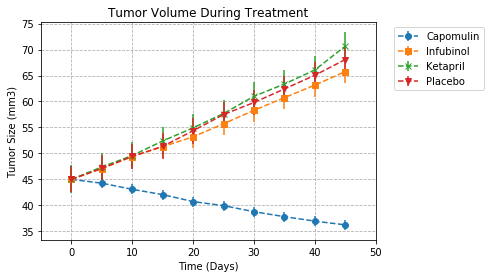

In [17]:
create_basic_scatter('Tumor Volume (mm3)')

#title
plt.title('Tumor Volume During Treatment')

#axes labels
plt.xlabel('Time (Days)')
plt.ylabel('Tumor Size (mm3)')

#show plot
plt.show()

# Scatter plot, number of metastatic sites for each treatment

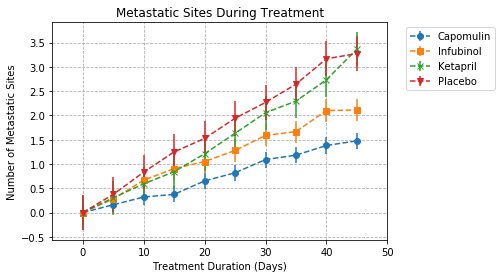

In [14]:
create_basic_scatter('Metastatic Sites')

#title
plt.title('Metastatic Sites During Treatment')

#axes labels
plt.xlabel('Treatment Duration (Days)')
plt.ylabel('Number of Metastatic Sites')

#show plot
plt.show()

# Scatter plot, survival rates for each treatment

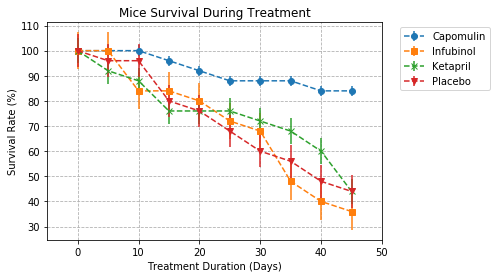

In [13]:
# How can I make create_basic_scatter() more flexible so that I can easily input this?

#Creates a groupby object for mean of tumor sizes by drug and timepoint, then converts to DF
survival_group = trial_data.groupby(['Drug', 'Timepoint'])['Mouse ID'].count()
survival = survival_group.to_frame()

#Re-arranging the format of the multi-index DF for insertion into a scatter plot
survival = survival.unstack().transpose().reset_index(level=0, drop=True)

#Create data for x-axis (time) and labels (drug names)
timepoint = survival.index
drugs = survival.columns

#standard error calculation for error bar
standard_error=survival.sem()/25 * 100

#Need to figure out a better way to do the above that's dynamic, only works right now because each trial has 25 mice

#marker array to cycle through in loop for data point differentiation
markers = ['o', 's', 'x', 'v']

#loop through each unique drug in drug name, and create scatter plot w/ error bars
for x in range(len(drugs)):

    surviving_mice=survival.iloc[:, x]
    
    initial_mice=survival.iloc[0, x]

    marker_position = (x)%4
    
    plt.errorbar(timepoint, surviving_mice/initial_mice * 100, yerr=standard_error[x], marker=markers[marker_position], linestyle='dashed')
    
#title
plt.title('Mice Survival During Treatment')

#grids
plt.grid(linestyle='dashed')

#limits
plt.xlim(min(timepoint)-5, max(timepoint)+5)

#axes labels
plt.xlabel('Treatment Duration (Days)')
plt.ylabel('Survival Rate (%)')

#anchors legend to outside of the chart
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#show plot
plt.show()

# Bar chart, tumor volume percent change for each treatment

<Container object of 4 artists>

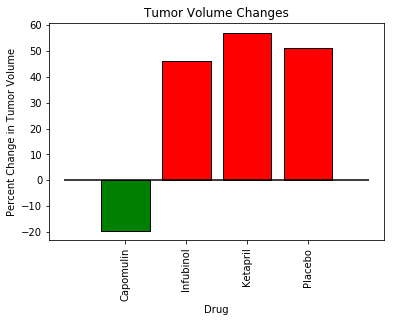

In [19]:
#This utilizes the same volume groupby object and DF as the first scatter chart.
#Look into how to minimize this code redundancy.
#Creates a groupby object for mean of tumor sizes by drug and timepoint, then converts to DF
tumor_volume_group = trial_data.groupby(['Drug', 'Timepoint'])['Tumor Volume (mm3)'].mean()
tumor_volume = tumor_volume_group.to_frame()

#Re-arranging the format of the multi-index DF for insertion into a scatter plot
tumor_volume = tumor_volume.unstack().transpose().reset_index(level=0, drop=True)

#Blank list to track % change for each treatment
tumor_changes = []

#Blank list to track whether % change is up or down, and colors to assign
bar_colors =[]

for x in range(len(drugs)):

    initial_tumor_size=tumor_volume.iloc[0,x]
    final_tumor_size=tumor_volume.iloc[-1,x]
    tumor_change = (final_tumor_size - initial_tumor_size) / initial_tumor_size*100
    tumor_changes.append(tumor_change)
    
    # adds to bar_colors list and provides a color based on positive/negative value
    if (tumor_change > 0):     
        bar_colors.append('red')
    else:
        bar_colors.append('green')

plt.title('Tumor Volume Changes')        

plt.hlines(0,-1,len(tumor_changes))

plt.xticks(rotation='vertical')

plt.xlabel('Drug')

plt.ylabel('Percent Change in Tumor Volume')

plt.bar(drugs, tumor_changes, color=bar_colors, edgecolor='black')

In [7]:
#Creates a groupby object for mean of tumor sizes by drug and timepoint, then converts to DF
tumor_volume_group = trial_data.groupby(['Drug', 'Timepoint'])['Tumor Volume (mm3)'].mean()
tumor_volume = tumor_volume_group.to_frame()

#Re-arranging the format of the multi-index DF for insertion into a scatter plot
tumor_volume = tumor_volume.unstack().transpose().reset_index(level=0, drop=True)